In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import cv2

# Load the decoder model
decoder = load_model('/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/decoder_model_April16.h5')

Mounted at /content/drive/


In [2]:
import os
import cv2
from sklearn.model_selection import train_test_split

def load_images(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder_path, filename))
            img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
            img = img[:,:,::-1]
            img_array = np.array(img) / 255.0
            image_list.append(img_array)
    return np.array(image_list)

folder_path = "/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/data/smd"
x_data = load_images(folder_path)
x_data.shape

(1347, 64, 64, 3)

In [3]:
import tensorflow as tf
import numpy as np

dataset = tf.data.Dataset.from_tensor_slices(x_data)

# Set the batch size
BATCH_SIZE = 128
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [4]:
def denormalize(image):
    return image

def display_image(image):
    denorm_image = denormalize(image)
    plt.imshow(denorm_image)
    plt.axis('off')
    plt.show()

def display_batch(images, title):
    fig = plt.figure(figsize=(6, 6))
    plt.suptitle(title)

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import InputLayer, Lambda, Dense, Flatten,LeakyReLU,Conv2D,Activation


LATENT_DIM = 256
NOISE_DIM = 512
IMAGE_SIZE = 64

def sampling(args):
    z_mean, z_log_var = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.keras.backend.random_normal(shape=(batch_size, LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def generator(decoder, noise_dim=NOISE_DIM):
    """
    Generate image from noise 
    Inputs:
    - decoder: pretrain model for genrate image freom mean and std
    - noise_dim: the dimension of the noise 
    
    Returns:
    TensorFlow Tensor with shape [number of image in one batch, 64, 64, 3]
    """

    # Freeze layers in the saved model
    for i, layer in enumerate(decoder.layers):

        # Check if it's not the last layer
        if i != len(decoder.layers) - 2:
          layer.trainable = False
        else:
          layer.trainable = True
        
        layer._name = f'saved_model_{i}_{layer.name}'


    model = Sequential([
        tf.keras.Input(shape=noise_dim),
        tf.keras.layers.Reshape((16, 16, 2)),
        tf.keras.layers.Conv2D(32, 3, activation=LeakyReLU(), padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation=LeakyReLU(), padding='same'),
        tf.keras.layers.Conv2D(128, 3, activation=LeakyReLU(), padding='same'),
        tf.keras.layers.Dropout(0.25),
        Flatten(),
        Dense(256, input_dim=noise_dim, activation=LeakyReLU()),
        Dense(512, activation=LeakyReLU()),
        Dense(512, activation=LeakyReLU()),
        Lambda(lambda x: sampling([x[:, :256], x[:, 256:]]))
    ])
    
    # Add layers from the saved model
    for layer in decoder.layers:
        model.add(layer)

    model.add(Activation('tanh'))

    return model

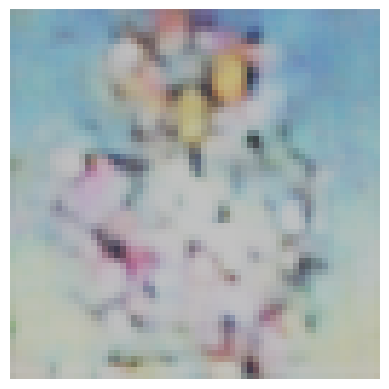

In [6]:
generator_model = generator(decoder)
noise_example = np.random.rand(2, NOISE_DIM) # suppose 2 images in one batch
output_fake = generator_model(noise_example) # (2,49152) tensor

# Let's check the image
output_reshape = output_fake.numpy()#.reshape(-1,64,64,3)
display_image(output_reshape[0])

In [7]:
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 16, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        608       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8

In [8]:
def discriminator(input_shape=(64,64,3)):
  
    """Compute discriminator score for a batch of input images.
      
    Inputs:
    - x: tensor, shape [number of images in one batch, 64, 64, 3]
    
    Returns:
    TensorFlow Tensor with shape [number of images in one batch, 1], containing the score 
    for an image being real for each input image.
    """

    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Reshape((IMAGE_SIZE,IMAGE_SIZE,3), input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',input_shape = input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

discriminator_model = discriminator()

In [9]:
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 256)         295168    
                                                      

In [10]:
# construct discriminator loss
def generator_loss(fake_score):
    """
    Input:
    fake_score is the result from discriminator, which is a [number of images in one batch, 1] tensor

    Returns:
    output the distance between fake_score and all 1 [number of images in one batch, 1] tensor by using BinaryCrossentropy
    output is a 1 D tensor which contain the average batch loss value. Since we use reduction = 'sum_over_batch_size'
    """
    # We need our generator loss as close as possible to 1, since 1 represent we fool the discrimiator.
    target = tf.ones_like(fake_score) # Tensor that contan batch_size number of 1. 
    loss = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target,fake_score)
    return loss


def disciminator_loss(fake_score,real_score):
    """
    Input
    fake_score is the result from discriminator by judging the fake image, which is a batch_size * 1 tensor
    real_score is the result from discriminator by judging the real image, which is a batch_size * 1 tensor

    Returns:
    the distance between fake_score and all 0 [number of images in one batch, 1] tebsor by using BinaryCrossentropy
    +  the distance between real_score and all 1 [number of images in one batch, 1] tensor by using BinaryCrossentropy
    =  1 D tensor which contain the average batch loss value. Since we use reduction = 'sum_over_batch_size'
    """
    target_real = tf.ones_like(real_score)
    loss_real = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target_real,real_score)

    target_fake = tf.zeros_like(fake_score)
    loss_fake = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target_fake,fake_score)

    return loss_real + loss_fake


In [11]:
import tensorflow as tf

initial_learning_rate_generator = 2e-5
initial_learning_rate_discriminator = 1e-5
decay_steps = 1000
decay_rate_generator = 0.95
decay_rate_discriminator = 0.90

lr_schedule_generator = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_generator,
    decay_steps=decay_steps,
    decay_rate=decay_rate_generator,
    staircase=True
)

lr_schedule_discriminator = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_discriminator,
    decay_steps=decay_steps,
    decay_rate=decay_rate_discriminator,
    staircase=True
)

In [12]:
@tf.function
def train_step(real_images,generator_model,discriminator_model,generator_optimizor,discriminator_optimizor):
    """
    Input
    real_images: All images in one batch
    generator_model: generator model, we declear outside generator = generator()
    discriminator_model: discriminator model, we declear outside discriminator = discriminator()
    generator_optimizor: generator_optimizor for generator
    discriminator_optimizor: discriminator_optimizor for discriminator

    Returns:
    the distance between fake_score and all 0 [number of images in one batch, 1] tebsor by using BinaryCrossentropy
    +  the distance between real_score and all 1 [number of images in one batch, 1] tensor by using BinaryCrossentropy
    =  1 D tensor which contain the average batch loss value. Since we use reduction = 'sum_over_batch_size'
    """
    # real_images.shape[0] represent the number of images in one batch
    noise = tf.random.normal([real_images.shape[0], NOISE_DIM])

    # Observe from tensorflow document
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

      # generate images: [number of images in one batch, 64 * 64 * 3] tensor
      fake_images = generator_model(noise, training=True)

      # Reshape images
      # fake_images = tf.reshape(fake_images,(-1,64,64,3))
      # real_images = tf.reshape(real_images,(-1,64,64,3))

      # calculate the score of fake_images and real_images: [number of images in one batch, 1] tensor
      fake_score = discriminator_model(fake_images, training=True)
      real_score = discriminator_model(real_images, training=True)

      # calculate the loss
      generator_loss_value = generator_loss(fake_score)
      # print(generator_loss_value)
      disciminator_loss_value = disciminator_loss(fake_score,real_score)
    
    # Update the weights of the model to minimize the loss value.
    generator_gradients = gen_tape.gradient(generator_loss_value, generator_model.trainable_weights)
    disciminator_gradients = dis_tape.gradient(disciminator_loss_value, discriminator_model.trainable_weights)

    generator_optimizor.apply_gradients(zip(generator_gradients, generator_model.trainable_weights))
    discriminator_optimizor.apply_gradients(zip(disciminator_gradients, discriminator_model.trainable_weights))

    return generator_loss_value,disciminator_loss_value,fake_images,fake_score,real_score


def train_gan(dataset, generator, discriminator, epochs):
    generator_optimizer = tf.keras.optimizers.Adam(lr_schedule_generator)
    discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule_discriminator)

    for epoch in range(epochs):
        gen_loss_sum = 0
        disc_loss_sum = 0
        num_batches = 0
        fake_score_sum = 0
        real_score_sum = 0

        for image_batch in dataset:
            gen_loss, disc_loss,fake_images,fake_score,real_score = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            gen_loss_sum += gen_loss
            disc_loss_sum += disc_loss
            num_batches += 1
            fake_score_sum += np.mean(fake_score.numpy())
            real_score_sum += np.mean(real_score.numpy())

        if epoch % 5 == 0:
          generated_images = fake_images.numpy()[0:9]
          denorm_images = [denormalize(img) for img in generated_images]
          display_batch(denorm_images, f"Generated images at epoch {epoch + 1}")

        
        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_sum/num_batches}, fake score: {fake_score_sum/num_batches}, Discriminator Loss: {disc_loss_sum/num_batches}, real score: {real_score_sum/num_batches}')

generator_model = generator(decoder)
discriminator_model = discriminator()
train_gan(dataset, generator_model, discriminator_model, epochs=100)